# Satellite Pass Visualization & Scheduler

**Location:** Beni Suef, Egypt
**Goal:** Identify the "Best Friends" in the sky — satellites that offer the most reliable data collection opportunities.

**Heuristic: "Total Observable Time"**
Satellites are ranked by the **total minutes** they are visible above 30° elevation over the next 48 hours. This balances:
1.  **Frequency:** (More passes = higher score)
2.  **Duration:** (Better passes = higher score)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skyfield.api import load, wgs84
from skyfield.timelib import Time
import datetime
from pathlib import Path
import matplotlib.dates as mdates

# Set aesthetic
sns.set_theme(style="whitegrid", palette="deep", rc={
    'axes.facecolor': '#fafafa',
    'figure.facecolor': '#fafafa'
})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.facecolor'] = '#fafafa'

## 1. Configuration & Data Loading

In [10]:
# Config
LOCATION_NAME = "Beni Suef, Egypt"
LATITUDE = 29.0661
LONGITUDE = 31.0994
ELEVATION_M = 32.0
MIN_ELEVATION = 30.0 # High quality passes only
HOURS_AHEAD = 48     # Analyze 48h window
TOP_N_SATS = 5       # Pick the Top 5 best satellites

DATA_DIR = Path('../data')
if not DATA_DIR.exists(): DATA_DIR = Path('data')
FIG_DIR = Path('../docs/figures')
if not FIG_DIR.exists(): FIG_DIR = Path('docs/figures')

# Load Targets
candidates = pd.read_csv(DATA_DIR / "golden_candidates.csv")
candidates['norad_cat_id'] = pd.to_numeric(candidates['norad_cat_id'], errors='coerce').fillna(0).astype(int)
target_ids = set(candidates['norad_cat_id'].tolist())

print(f"Candidate Pool: {len(target_ids)} satellites")

Candidate Pool: 39 satellites


## 2. Physics Engine (Skyfield)

In [11]:
# Load TLEs
satellites = load.tle_file("https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle", 
                          filename=str(DATA_DIR / "celestrak_active.txt"))
by_id = {sat.model.satnum: sat for sat in satellites}
my_sats = [by_id[nid] for nid in target_ids if nid in by_id]

# Setup Observer
ts = load.timescale()
t0 = ts.now()
t1 = ts.from_datetime(t0.utc_datetime() + datetime.timedelta(hours=HOURS_AHEAD))
ground_station = wgs84.latlon(LATITUDE, LONGITUDE, elevation_m=ELEVATION_M)

print(f"Simulating passes for {len(my_sats)} satellites over next {HOURS_AHEAD} hours...")

Simulating passes for 17 satellites over next 48 hours...


## 3. Scoring the Satellites
We simulate passes for *all* candidates first, then aggregate scores.

In [12]:
satellite_scores = []
all_passes = []

for sat in my_sats:
    # Find events
    times, events = sat.find_events(ground_station, t0, t1, altitude_degrees=MIN_ELEVATION)
    
    sat_passes = []
    total_duration = 0.0
    pass_count = 0
    max_el_overall = 0.0
    
    current_rise = None
    for ti, event in zip(times, events):
        if event == 0: # Rise
            current_rise = ti
        elif event == 2: # Set
            if current_rise is not None:
                start_dt = current_rise.utc_datetime()
                end_dt = ti.utc_datetime()
                duration = (end_dt - start_dt).total_seconds() / 60.0
                
                # Rough max el check (midpoint)
                mid_time = ts.from_datetime(start_dt + datetime.timedelta(minutes=duration/2))
                alt, _, _ = (sat - ground_station).at(mid_time).altaz()
                peak_el = alt.degrees
                
                if peak_el > max_el_overall:
                    max_el_overall = peak_el
                
                sat_passes.append({
                    "start": start_dt,
                    "end": end_dt,
                    "duration": duration,
                    "peak_el": peak_el
                })
                total_duration += duration
                pass_count += 1
            current_rise = None
            
    if pass_count > 0:
        name = candidates[candidates['norad_cat_id'] == sat.model.satnum].iloc[0]['amsat_name']
        satellite_scores.append({
            "name": name,
            "norad_id": sat.model.satnum,
            "total_duration": total_duration,
            "pass_count": pass_count,
            "max_el": max_el_overall,
            "obj": sat, # Keep object for detailed plotting later
            "passes": sat_passes
        })

# Sort by Total Duration
satellite_scores.sort(key=lambda x: x['total_duration'], reverse=True)
top_sats = satellite_scores[:TOP_N_SATS]

## 3.1 The Winners (Top 5)
These are the satellites you should focus on.

In [13]:
df_scores = pd.DataFrame(top_sats).drop(columns=['obj', 'passes'])
print("Top Satellites by Total Observable Time:")
print(df_scores[['name', 'pass_count', 'total_duration', 'max_el']].to_string(index=False))

Top Satellites by Total Observable Time:
              name  pass_count  total_duration    max_el
   STEP CubeLab-II           3       12.144683 81.588028
          STRaND-1           3       11.849479 62.196917
TechSat-1B (GO-32)           2        8.742256 49.913177
          UniSat-6           2        8.293440 77.615462
          TigriSat           2        8.272842 85.426374


## 4. Detailed Calculation for Visualization
Now we generate the high-res tracks ONLY for the winners.

In [14]:
tracks = []

for sat_data in top_sats:
    sat = sat_data['obj']
    # Re-run precise calculation for plotting
    times, events = sat.find_events(ground_station, t0, t1, altitude_degrees=MIN_ELEVATION)
    
    current_rise = None
    for ti, event in zip(times, events):
        if event == 0: current_rise = ti
        elif event == 2:
            if current_rise is not None:
                # High-res sampling
                num_points = 50 
                t_samples = ts.linspace(current_rise, ti, num_points)
                topocentric = (sat - ground_station).at(t_samples)
                alt, az, _ = topocentric.altaz()
                
                start_dt = current_rise.utc_datetime()
                duration = (ti.utc_datetime() - start_dt).total_seconds() / 60
                
                tracks.append({
                    "name": sat_data['name'],
                    "times": t_samples.utc_datetime(),
                    "azimuth": az.degrees,
                    "elevation": alt.degrees,
                    "max_el": alt.degrees.max(),
                    "start_time": start_dt,
                    "duration_min": duration
                })
            current_rise = None

## 5. Skyplot: The Winners' Paths
Showing all passes for the Top 5 satellites.

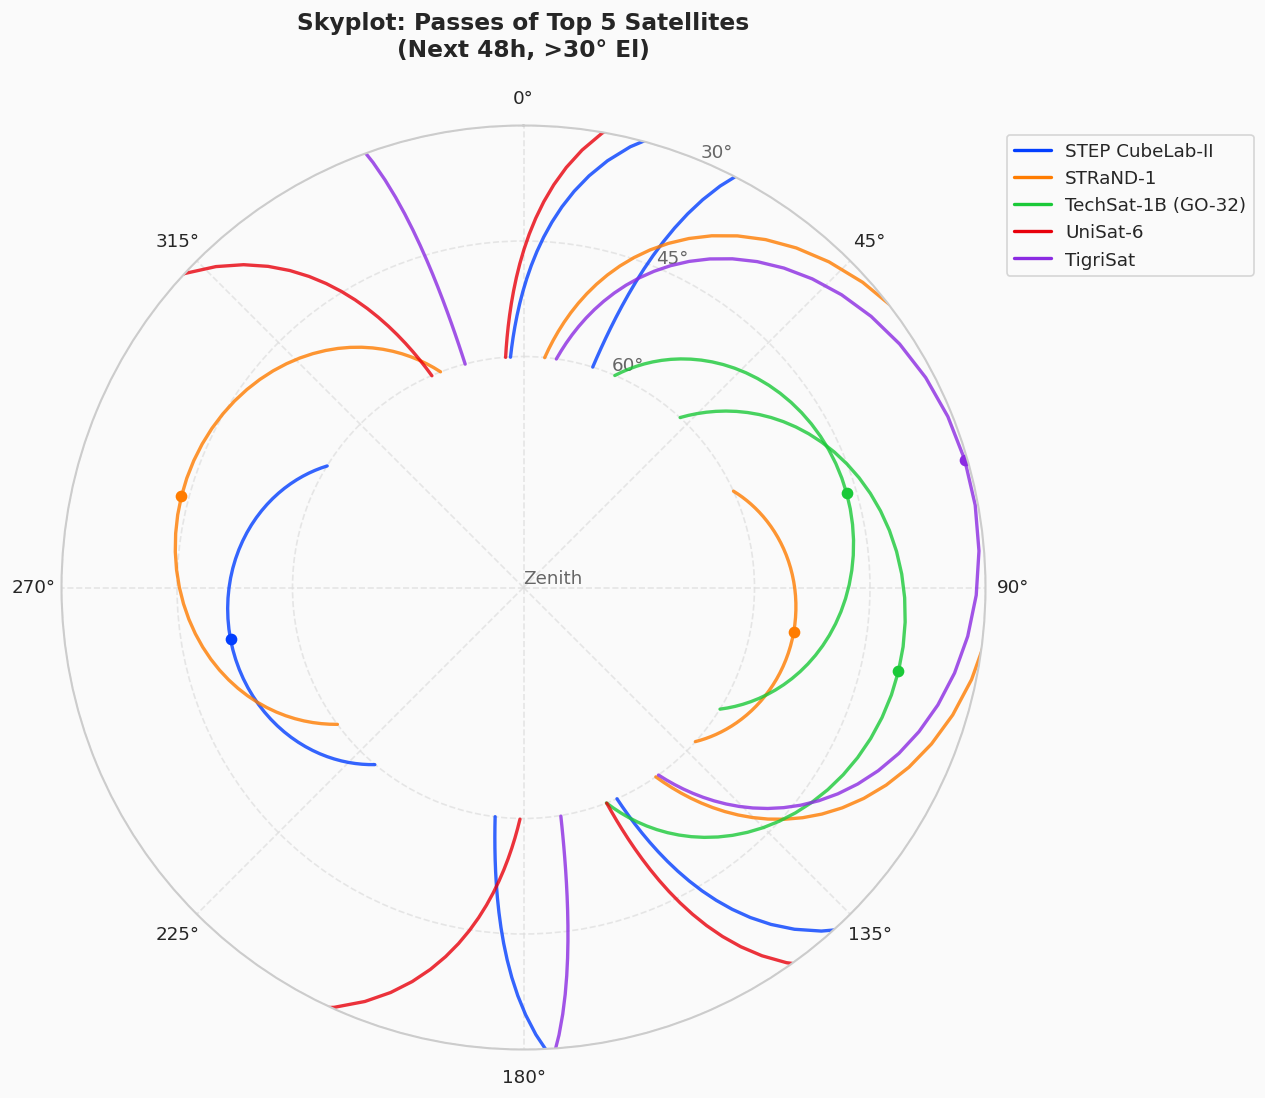

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(90, 30)
ax.set_yticks([30, 45, 60, 90])
ax.set_yticklabels(['30°', '45°', '60°', 'Zenith'], color='#666666')
ax.grid(True, color='#DDDDDD', linestyle='--', alpha=0.7)

# Color by Satellite Name
unique_names = [s['name'] for s in top_sats]
palette = sns.color_palette("bright", len(unique_names))
color_map = {name: color for name, color in zip(unique_names, palette)}

for track in tracks:
    c = color_map[track['name']]
    az_rad = np.radians(track['azimuth'])
    el = track['elevation']
    
    # Path
    ax.plot(az_rad, 90-el, color=c, linewidth=2, alpha=0.8)
    # Peak
    max_idx = np.argmax(el)
    ax.plot(az_rad[max_idx], 90-el[max_idx], 'o', color=c, markersize=6)
    
# Custom Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color_map[n], lw=2, label=n) for n in unique_names]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.title(f"Skyplot: Passes of Top {TOP_N_SATS} Satellites\n(Next {HOURS_AHEAD}h, >30° El)", pad=20, fontsize=14, fontweight='bold')
plt.savefig(FIG_DIR / 'skyplot_top_candidates.png', bbox_inches='tight', dpi=150)
plt.show()

## 6. Timeline: When to Watch
Notice how some satellites (like GO-32) might appear multiple times.

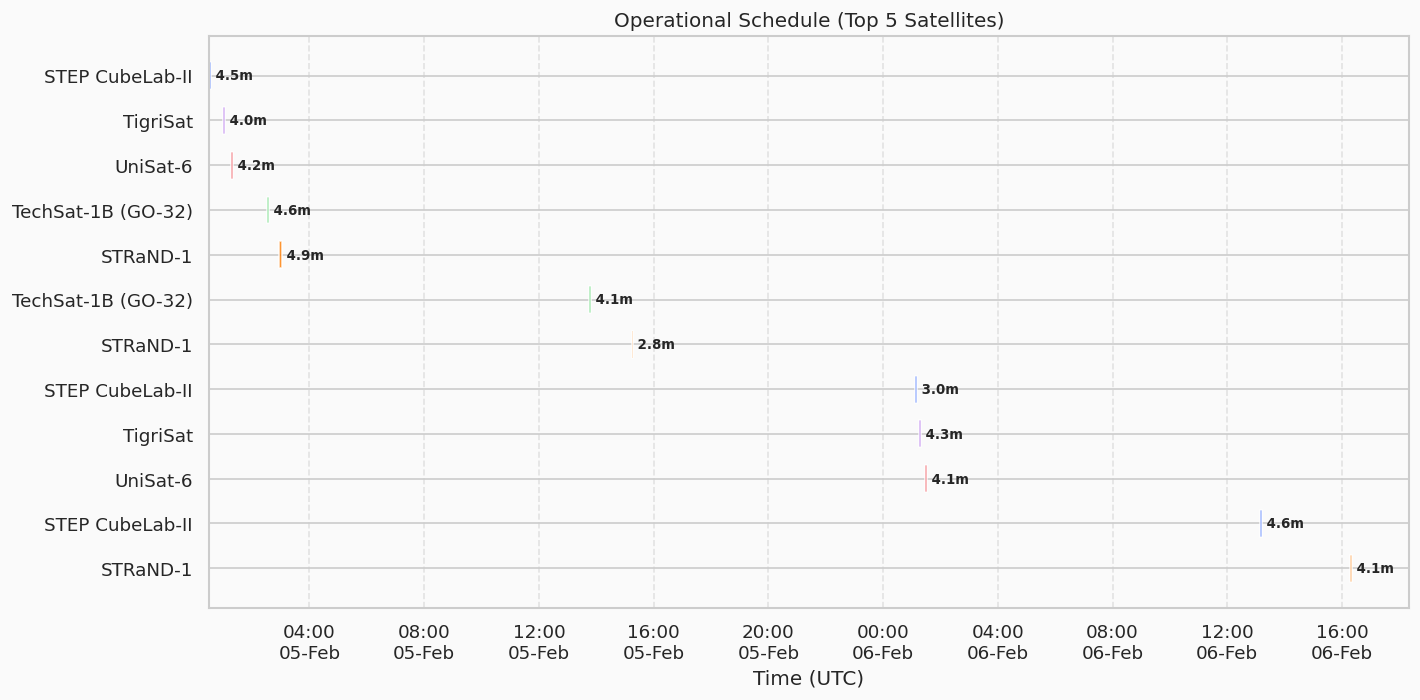

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

tracks.sort(key=lambda x: x['start_time'])

y_pos = np.arange(len(tracks))
start_times = [t['start_time'] for t in tracks]
durations_min = [t['duration_min'] for t in tracks]
names = [t['name'] for t in tracks]
colors = [color_map[n] for n in names]

# Duration to days
durations_days = [d / (24 * 60) for d in durations_min]

bars = ax.barh(y_pos, durations_days, left=mdates.date2num(start_times), height=0.6, color=colors, alpha=0.8)

for i, rect in enumerate(bars):
    width_days = rect.get_width()
    width_min = width_days * 24 * 60
    ax.text(rect.get_x() + width_days, rect.get_y() + rect.get_height()/2, 
            f" {width_min:.1f}m", ha='left', va='center', fontsize=8, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))
ax.invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.title("Operational Schedule (Top 5 Satellites)")
plt.xlabel("Time (UTC)")
plt.tight_layout()
plt.savefig(FIG_DIR / 'timeline_schedule.png', bbox_inches='tight', dpi=150)
plt.show()